# Final Project - Advanced Topics in Computer Science 8

Yehonatan Peisakhovsky yehonatan-pe@campus.technion.ac.il 316411735

Ido Zuckerman ido.z@campus.technion.ac.il 323102830

## Topic
Strategic classification, specifically the behavior of strategic suppliers in information retrieval.

## Introduction
In the domain of information retrieval, which is closely related to recommendation systems, the objective of the information retrieval system is to retrieve relevant information from a large collection of data in response to a user's query. It does so by finding the documents with the highest probability of being relevant to the user’s query.
But the objective of the content creators, the ones who are creating the data, is to get as many people as possible to read their content (like news sites), buy products from them (like amazon, eBay and etc.) or to expose visitors to advertisement on the site. For all those reasons, content creators objective is to get people to chose their document to consume.
Because content creators want the highest exposure (as it usually translates to more users consuming their data), they would want to be ranked as high as possible to as many queries as possible. So, content creators might change their content, to be ranked higher and receive higher exposure, even if the changes are superficial and meant only for the benefit of higher ratings.
And because not all queries carry the same value (for example, a user searching for a new phone carries much more value to an Ecommerce site than a user searching for bottle water), then content creators might want to tailor their data to fit best to the higher value queries.
In our work, we chose to explore how such strategic behavior of the content creators affects the overall performance of the information retrieval system, and the affect of the strategic behavior of the content creators on their revenue.


## Research Question
How does strategic behavior of content creators affect system integrity?
How does strategic behavior of content creators affect their revenue?


## Assumptions
Our assumptions are:
1.	Different information retrieval systems will show different behavior exposed to
2.	Using strategic behavior will lead to decreased performance of the information retrieval system.
3.	Strategic behavior of content creators will lead to an increase in their revenue only to a certain point, meaning if there are too many strategic agents, strategic behavior might not add additional revenue.



## Methods and Experiments
To assess the validity of our assumptions, we employed a number of methodologies. The approaches involved simulating diverse scenarios to gauge their impact on the performance of the system.

In particular, we manipulated the percentage of strategic agents and the number of words they added to their documents and assessed their effect on the system's performance. For each simulation, a proportion p of the agents were designated as strategic, and allowed to add w words to their documents.

To quantify the performance of the system, we computed the Normalized Discounted Cumulative Gain (NDCG) per query. This metric enabled us to assess the relevance and ranking of the search results. By comparing the NDCG values across different settings, we gained insights into how the behavior of strategic agents influenced the overall performance of the system.

In our work we used the models Okapi BM25, TF-IDF, and Rank SVM which are all methods used in Information Retrieval (IR) to rank documents based on their relevance to a given query.

* Okapi BM25 is a ranking function that takes into account the frequency of query terms in the document, the length of the document, and the frequency of the query terms across all documents in the corpus. It is a popular ranking function used in search engines.
* TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical method that gives weight to each term in a document based on its frequency in the document and inverse frequency in the corpus. The more frequent a term is in a document and the less frequent it is in the corpus, the higher the weight it will have.
* Rank SVM is a machine learning algorithm that is used for ranking documents. It is based on Support Vector Machines (SVMs), a popular algorithm used for classification. In Rank SVM, the goal is to learn a ranking function that can predict the relevance of a document to a given query. It works by training on pairs of documents and their corresponding relevance scores, and then using the learned function to rank new documents.

As for our part of adding words to the documents of each agent, we used two different techniques that we developed, "Top k softmax" and "dominant word not present" for text generation. Both approaches use the log of the frequency of words in the queries and the queries values in order to create a “value” for each word, which is used the strategies we deviced later. The value of each word is calculate based on the following formula:
$$v_w=\sum_{q}{log(count(w+1)) \cdot q_{worth}}$$

This way a word gets a high value if it appears a lot in multiple high value queries, and the log is there in order to avoid giving word too much weight). After the words values are calculated, the strategies do the following things.

* Top k SoftMax is – chose the top k most valued words, use SoftMax on their values (with temperature) and then add the amount of words available according to the resulting distribution.
  $$p_w_i=\frac{e^{v_w_i/T}}{{\sum_{i=1}^{k}{e^{c_w_i/T}}}$$
* Dominant word not present -Use the word values to calculate most valued word and add to the text the most valued word not appearing in the document as many times as possible.

We drew inspiration from ndcg to calculate the revenue of the agents. We wanted to see the affect of strategic behavior of content creators on their revenue. As there are no real metrics to evaluate revenue based on ranking, we devised one. Each agents revenue is calculated in the following way:
$$R_a=\sum_{q}{\frac{1}{log(r_{a,q}+1)}\cdot q_{worth}}$$

Meaning revenue of each agent ($R_a$) is the sum on all queries of the inverse of log on the ranking of the document in the current query list ($r_{a.q}$) times the queries worth. We used the inverse on the log if the ranking as in ndcg, because this gives much more influence to top positions.
Because this is a metric we devised, the actual number is meaningless, so the metric we chose to evaluate was the total revenue of the strategic agents after they applied their strategy to their revenue before they applied their strategy. We named it improvement ratio ($I_{ratio}$)

$$I_{ratio}=\frac{\sum_{a}{R_{a,after}}}{\sum_{a}{R_{a,before}}}$$

This gives us a general idea of how well the strategic agents changed their position based both on ranking and query worth.

In order to use our methods we employed the CISI dataset, which is available at https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval. This dataset was originally collected by the Centre for Inventions and Scientific Information (CISI) and comprises textual information on 1,460 documents and 112 associated queries. The primary aim of utilizing this dataset was to construct models of information retrieval (IR), wherein a given query is expected to retrieve a set of document IDs that are most relevant to the query.

In our experiments we are going to create an environment in which a subset of p agents is designated as strategic. Each strategic agent is permitted to add w words to their document. The queries will be partitioned into five distinct folds to enable cross-validation. Specifically, the environment will be trained on four folds and tested on the remaining one, with this procedure repeated for each of the five folds. In addition, for each configuration (4 train folders and 1 test folder), we do 5 epochs in which we rechose the strategic agents, to get more robust results. The system will be evaluated based on the results of the tests, which will enable the calculation of the NDCG and the agents' revenue. This evaluation will allow us to address our research questions. We will try to run the environment with different models, strategies, percentage of strategic agents, and number of words added by the strategic agents.


## Results

In [1]:
from enviorment import Env
from utils import *
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import random
from collections import defaultdict
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idozu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Hyperparameters

In [2]:
amount_of_queries = 50
k = 5
Epochs = 3

#### Preprocess

In [3]:
docs, queries, rel = create_documents_queries_and_relevence()
queries_with_relevant_docs = list(rel.keys())
queries = {k: queries[k] for k in queries_with_relevant_docs}
docs, queries = preprocess_data(docs, queries)

# Temp Experiments

In [4]:
def run_exp(strategic_per_nums, number_of_word_to_add_nums, model, k=4, strategy="top_k_softmax"):
    agents_params = {"strategy": strategy, "k": k, "t": 100}
    print(f"\nModel: {model}\tstrategic_per: {strategic_per_nums}\tnumber_of_word_to_add: {number_of_word_to_add_nums}"
          f"\tstrategy: {strategy}\tk: {k}")
    # Preprocess
    docs, queries, rel = create_documents_queries_and_relevence()
    queries_with_relevant_docs = list(rel.keys())
    queries = {k: queries[k] for k in queries_with_relevant_docs}
    docs, queries = preprocess_data(docs, queries)

    # Chosen queries to work with and do cross validation
    chosen_queries = [x for x in queries.keys()][:amount_of_queries]
    cv = KFold(5)
    undisturbed_ndcgs = defaultdict(float)
    disturbed_ndcgs = defaultdict(float)
    agents_values = defaultdict(float)
    for strategic_per in tqdm(strategic_per_nums):
        for number_of_word_to_add in number_of_word_to_add_nums:
            # original ndcg without changing the documents
            undisturbed_ndcg = []
            # Ndcg after the change
            disturbed_ndcg = []
            agents_value = []
            for train_indices, test_indices in cv.split(chosen_queries):
                # The ids of the queries used to train,
                # they actually matter just when using rank svm
                train_queries_ids = [chosen_queries[x] for x in train_indices]
                # The ids of the queries used to test the model
                test_queries_ids = [chosen_queries[x] for x in test_indices]
                train_queries = {k: queries[k] for k in train_queries_ids}
                train_rel = {k: rel[k] for k in train_queries_ids}
                test_queries = {k: queries[k] for k in test_queries_ids}
                test_rel = {k: rel[k] for k in test_queries_ids}
                # Assigns random values to the queries, we can change seed
                queries_worth = create_queries_worth(test_queries)
                # Environment initialization
                environment = Env(docs=docs, strategic_percentage=strategic_per, model_type=model,
                                  number_of_word_to_add=number_of_word_to_add, train_queries=train_queries,
                                  train_relevance_ranking=train_rel, seed=10, agents_params=agents_params)
                # Epochs represents the amount of time we change which agents are chosen to
                # be strategic. We need to talk about how they are chosen, because now they are random
                # meaning if we run too many epochs then the ndcg with or without corruption will
                # be the same (because sometimes strategic agents are relevant and pushed up, sometimes
                # not relevant are pushed up.
                for i in range(Epochs):
                    environment.change_config()
                    # Scores of unchanged documents and real ndcg
                    queries_scores = environment.run(test_queries)
                    strategic_agents_value_pre_change = environment.calculate_strategic_revenue(test_queries,
                                                                                                queries_worth)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        undisturbed_ndcg.append(ndcg_score(gt, scores))
                    # Makes strategic agents change their documents
                    environment.corrupt(test_queries, queries_worth)
                    # Scores after documents change
                    queries_scores = environment.run(test_queries)
                    strategic_agents_value_post_change = environment.calculate_strategic_revenue(test_queries,
                                                                                                 queries_worth)
                    agents_value.append(strategic_agents_value_post_change / strategic_agents_value_pre_change)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        disturbed_ndcg.append(ndcg_score(gt, scores))
            # print(f"Undisturbed ndcg {np.mean(undisturbed_ndcg):.4f}")
            # print(f"Disturbed ndcg {np.mean(disturbed_ndcg):.4f}")
            undisturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(undisturbed_ndcg)
            disturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(disturbed_ndcg)
            agents_values[(strategic_per, number_of_word_to_add)] = np.mean(agents_value)

    figure, axis = plt.subplots(2, 2)
    figure.set_figwidth(15)
    figure.set_figheight(15)

    keys = np.array([[x, y, value] for (x, y), value in disturbed_ndcgs.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]
    plt.title(f"Model: {model}")
    different_y = np.unique(ydata)
    for y in different_y:
        axis[0, 0].plot(xdata[ydata == y], zdata[ydata == y], label=f"{y:.0f} Words Added")

    axis[0, 0].legend()
    axis[0, 0].set_xlabel("Strategic Percentage")
    axis[0, 0].set_ylabel("NDCG")
    axis[0, 0].set_title(f"Model: {model}")

    different_x = np.unique(xdata)
    for x in different_x:
        axis[0, 1].plot(ydata[xdata == x], zdata[xdata == x], label=f"{x:.1f} Strategic Percentage")
    axis[0, 1].legend()
    axis[0, 1].set_xlabel("Number of Words Added")
    axis[0, 1].set_ylabel("NDCG")
    axis[0, 1].set_title(f"Model: {model}")

    keys = np.array([[x, y, value] for (x, y), value in agents_values.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]

    different_y = np.unique(ydata)
    for y in different_y:
        axis[1, 0].plot(xdata[ydata == y], zdata[ydata == y], label=f"{y:.0f} Words Added")
    axis[1, 0].legend()
    axis[1, 0].set_xlabel("Strategic Percentage")
    axis[1, 0].set_ylabel("Revenue Ratio")
    axis[1, 0].set_title(f"Model: {model}")

    different_x = np.unique(xdata)
    for x in different_x:
        axis[1, 1].plot(ydata[xdata == x], zdata[xdata == x], label=f"{x:.1f} Strategic Percentage")
    axis[1, 1].legend()
    axis[1, 1].set_xlabel("Number of Words Added")
    axis[1, 1].set_ylabel("Revenue Ratio")
    axis[1, 1].set_title(f"Model: {model}")
    plt.show()

    # plt.plot()
    ax = plt.axes(projection='3d')
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    ax.dist = 13
    ax.set_xlabel("Strategic Percentage")
    ax.set_ylabel("Number of Word Added")
    ax.set_zlabel("Value")
    ax.set_title(f"Model: {model}")
    plt.show()

    ax = plt.axes(projection='3d')
    keys = np.array([[x, y, value] for (x, y), value in agents_values.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    ax.dist = 13
    ax.set_xlabel("Strategic Percentage")
    ax.set_ylabel("Number of Word Added")
    ax.set_zlabel("Agent Value")
    ax.set_title(f"Model: {model}")
    plt.show()


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


100%|██████████| 5/5 [45:48<00:00, 549.75s/it]


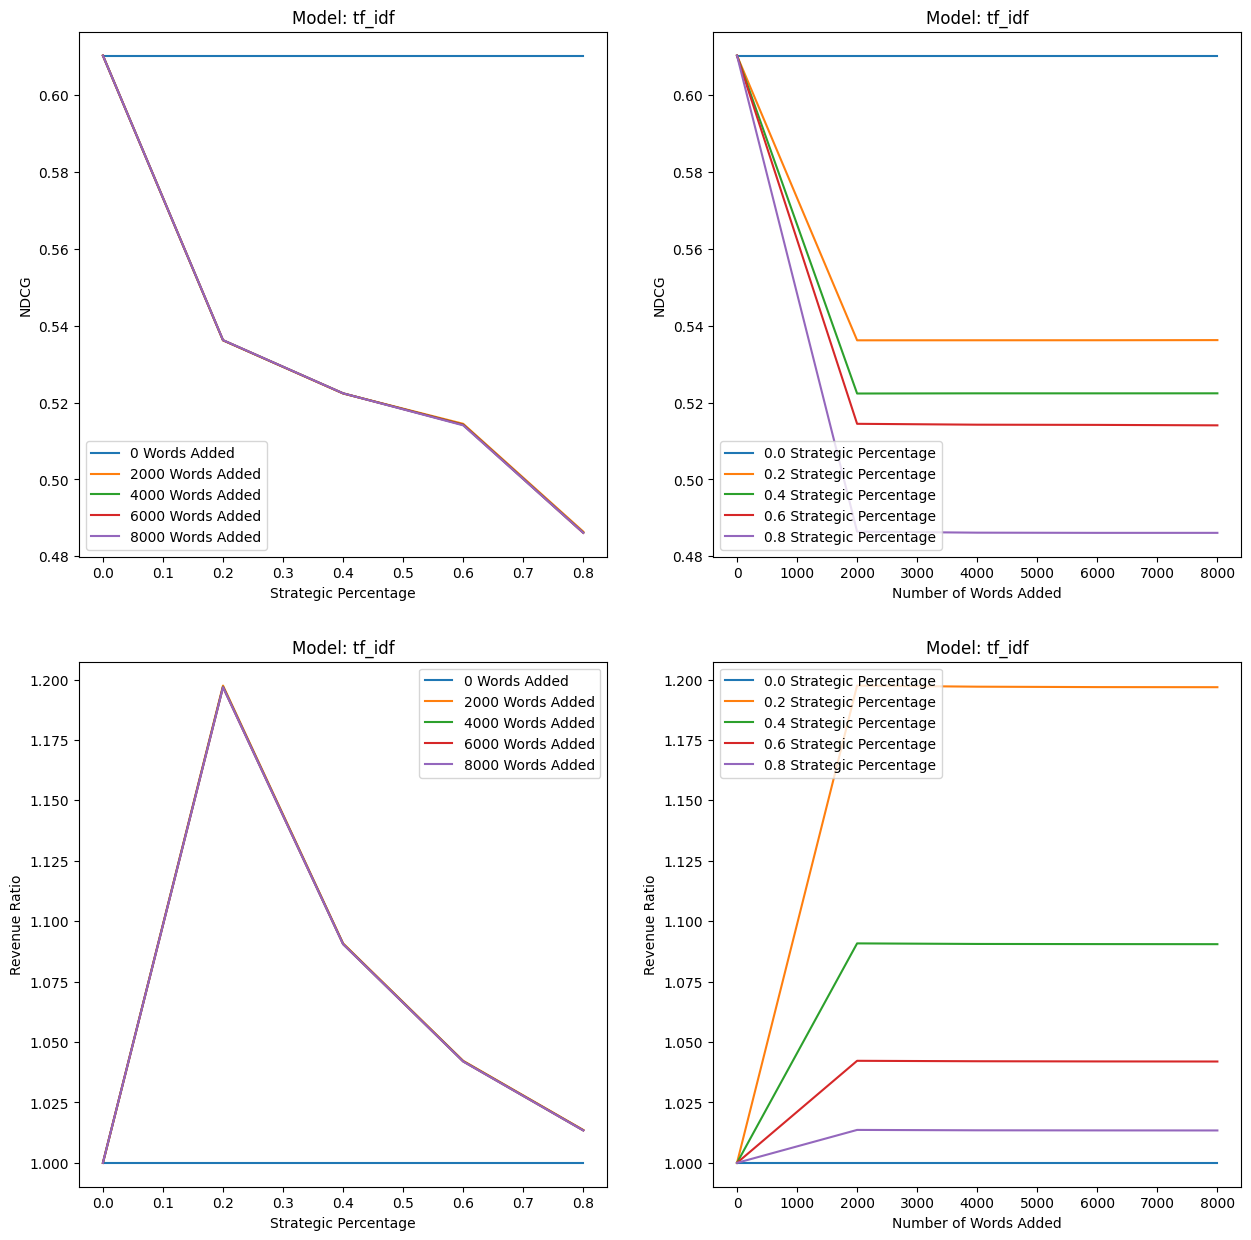

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


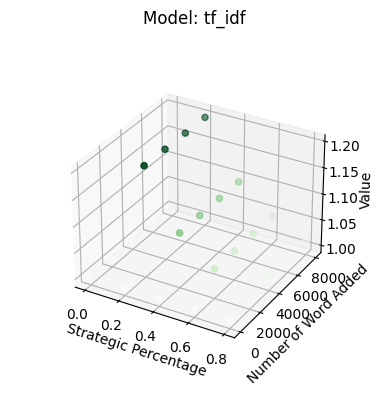

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


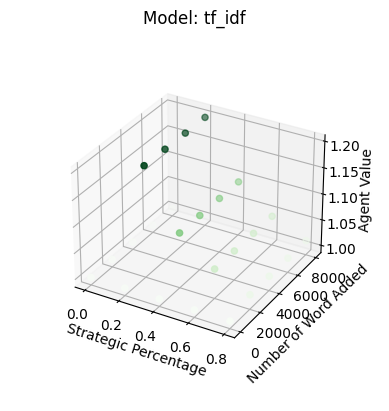

In [5]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf", strategy="dominant_word_not_present")


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


100%|██████████| 5/5 [35:51<00:00, 430.34s/it]


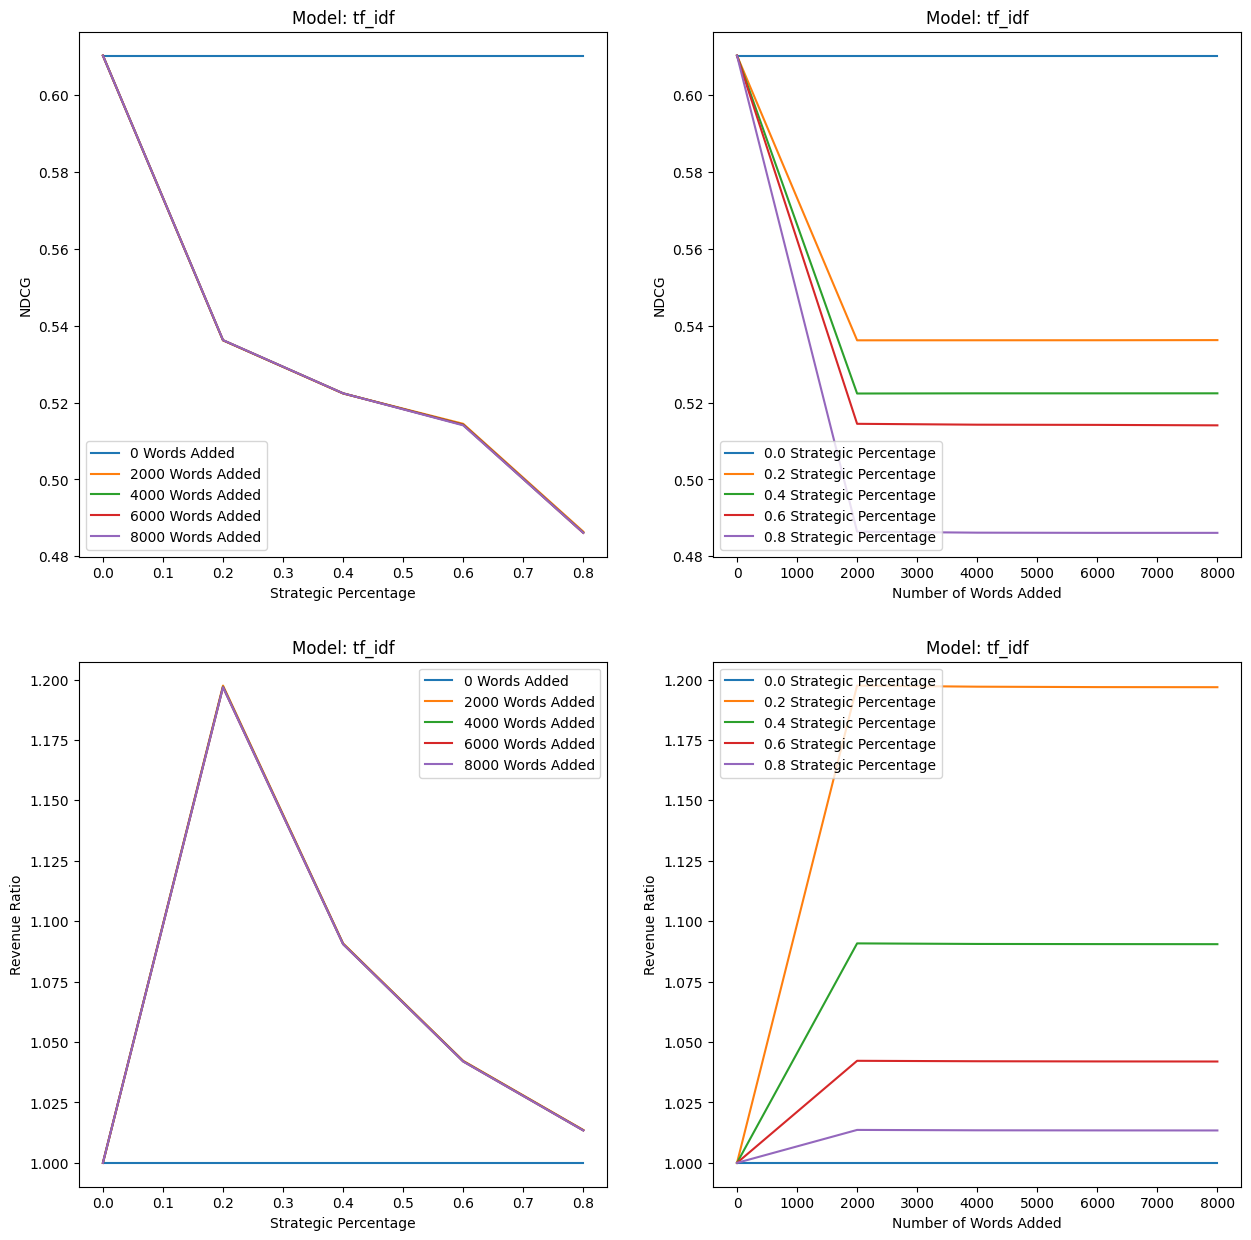

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


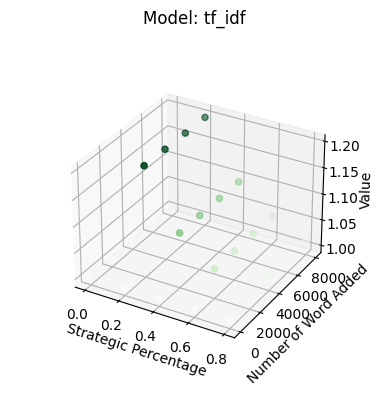

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


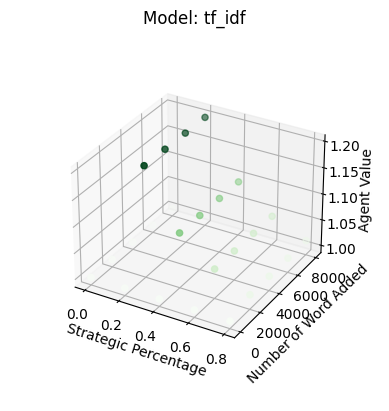

In [6]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf", strategy="dominant_word_not_present")

In our first experiment employed the TF-IDF model utilizing the dominant_word_not_present strategy. The findings indicate that the system value is highest when none of the agents are strategic, which occurs when the percentage of strategic agents or added words is equal to zero. Subsequently, an increase in the number of agents magnifies the effect of the decrease in the system value, as the system becomes increasingly disrupted. Additionally, the agents consistently generate profits, with their value consistently higher than 1. A higher number of added words results in a greater value for the agents since they are more likely to add a non-existent word, thereby increasing the document's relevance. But a higher percentage of strategic agents results in a lower value for the agents since they are starting to harm each other's profits.


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


100%|██████████| 5/5 [15:19<00:00, 183.90s/it]


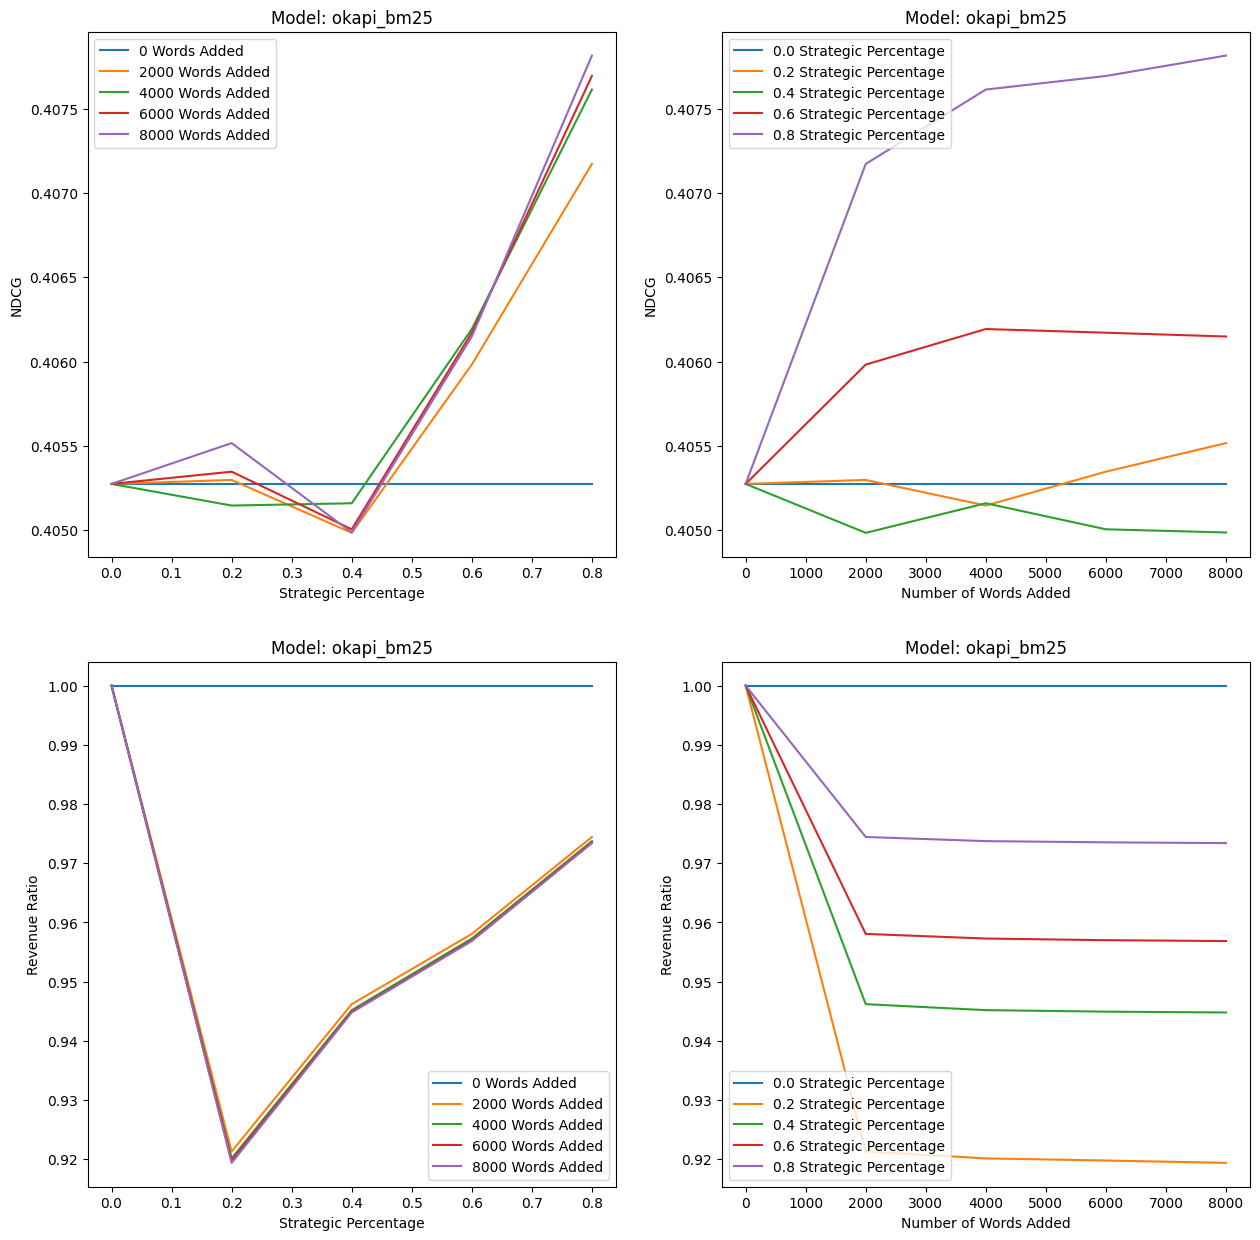

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


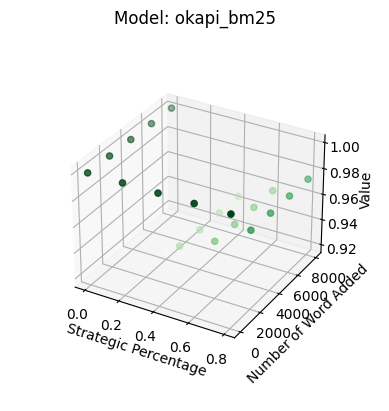

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


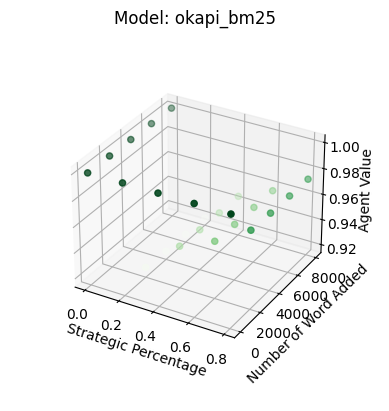

In [7]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "okapi_bm25", strategy="dominant_word_not_present")

In this experiment, the Okapi BM25 model was employed, utilizing the dominant_word_not_present approach. The results are the oppisite to the TF-IDF approch, we can see that the NDCG increases and the value for the strategic agents decreases as the number of strategic agents increases, but the changes are not as drastic as in the TF-IDF model. We believe it due to the fact that the model showed much worse results on the base case (NDCG of around 0.4) compared to 0.6 in the TF-IDF model.

I have no idea what to write here


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 1


100%|██████████| 5/5 [39:24<00:00, 472.90s/it]


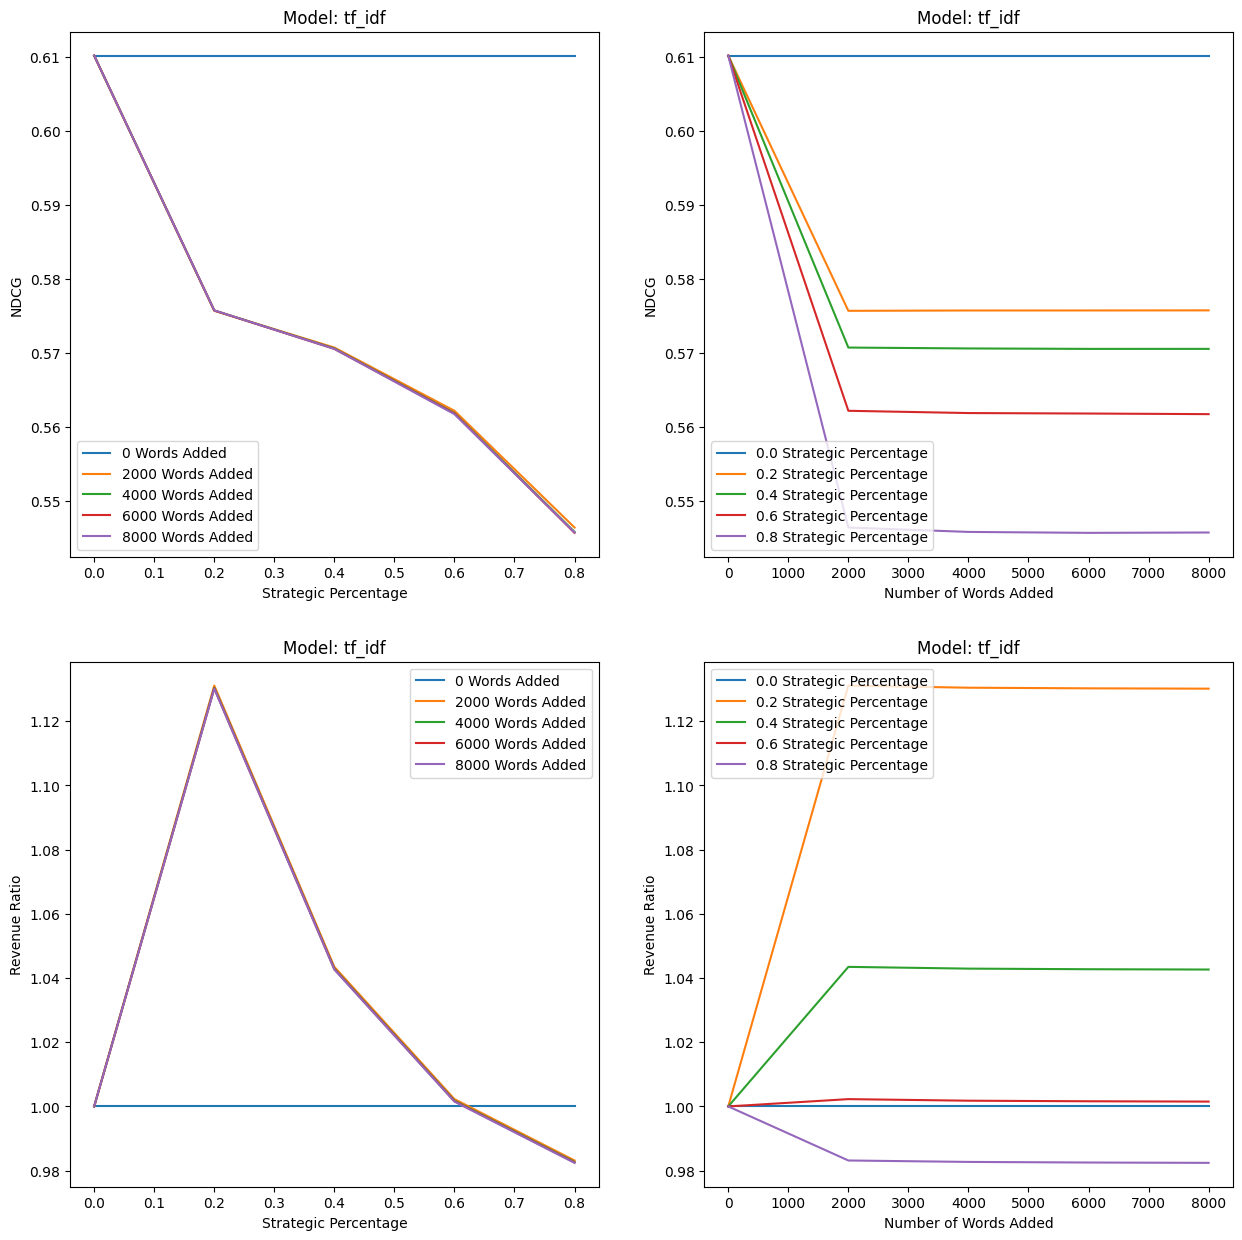

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


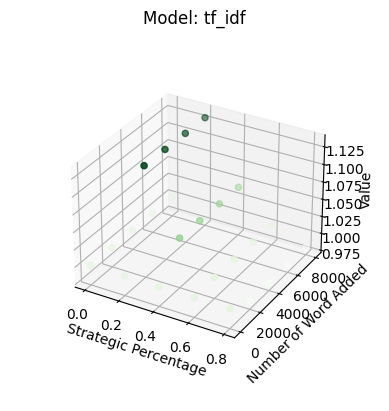

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


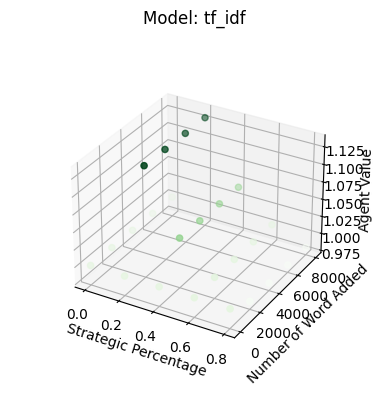


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 2


100%|██████████| 5/5 [39:44<00:00, 476.80s/it]


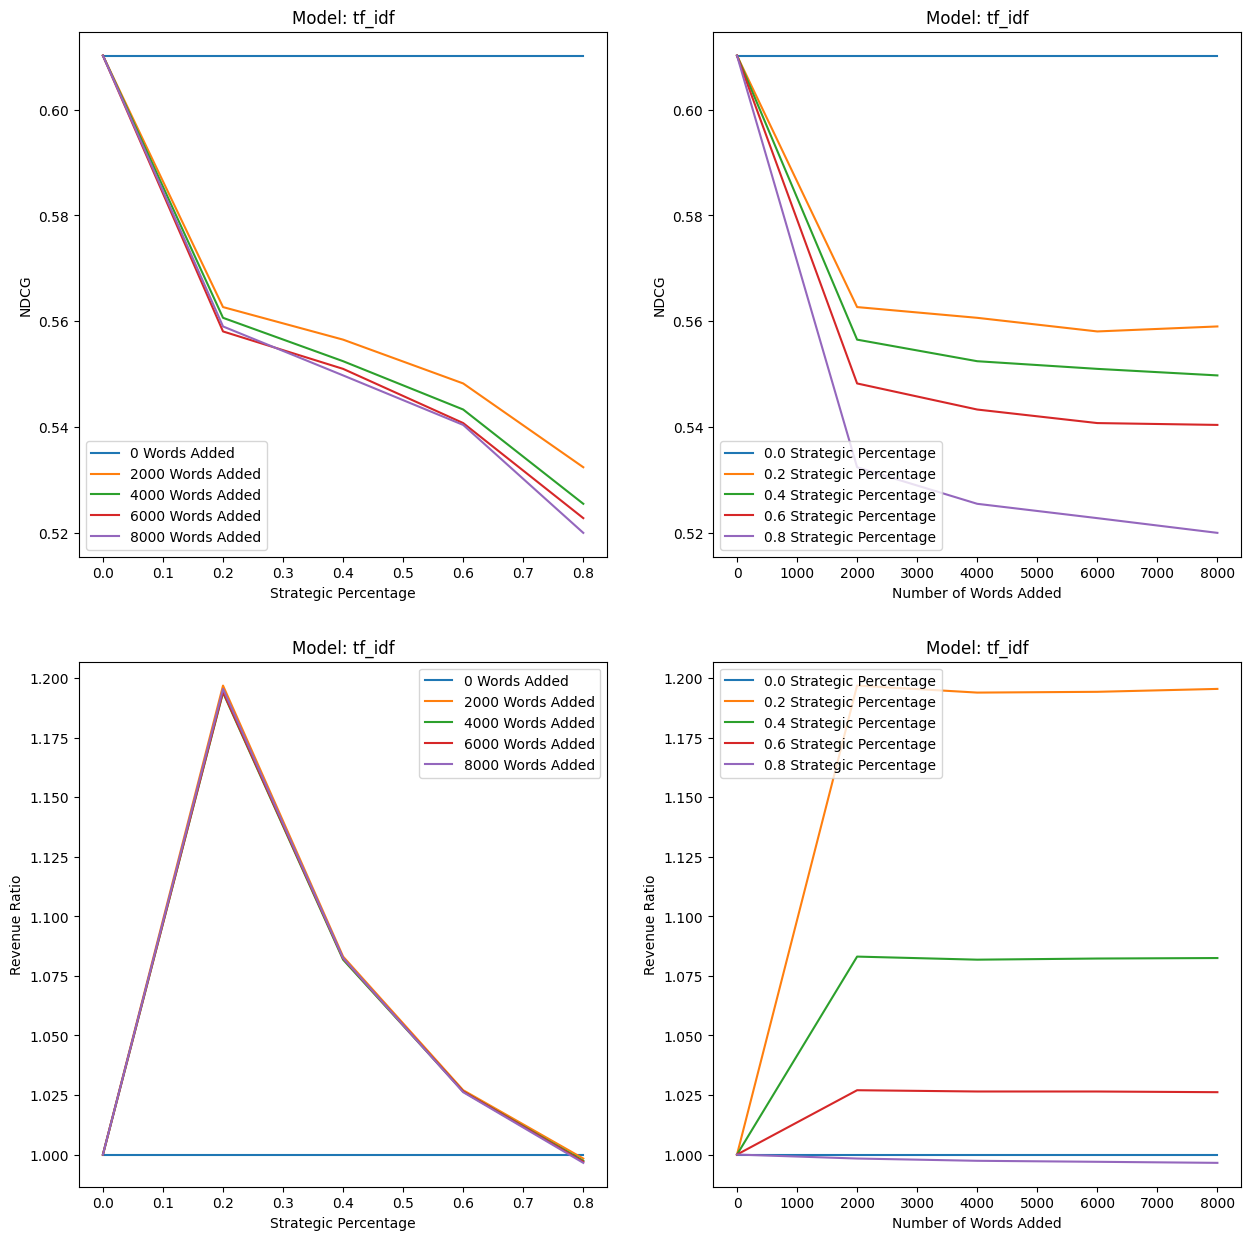

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


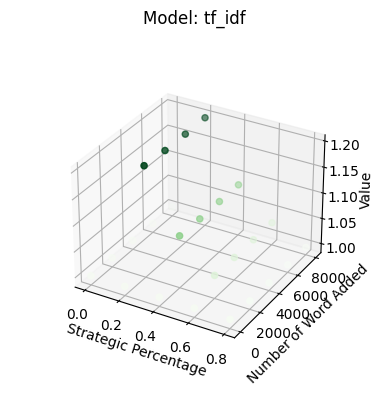

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


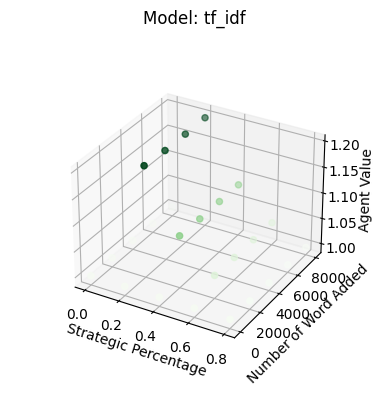


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 3


100%|██████████| 5/5 [50:37<00:00, 607.46s/it]


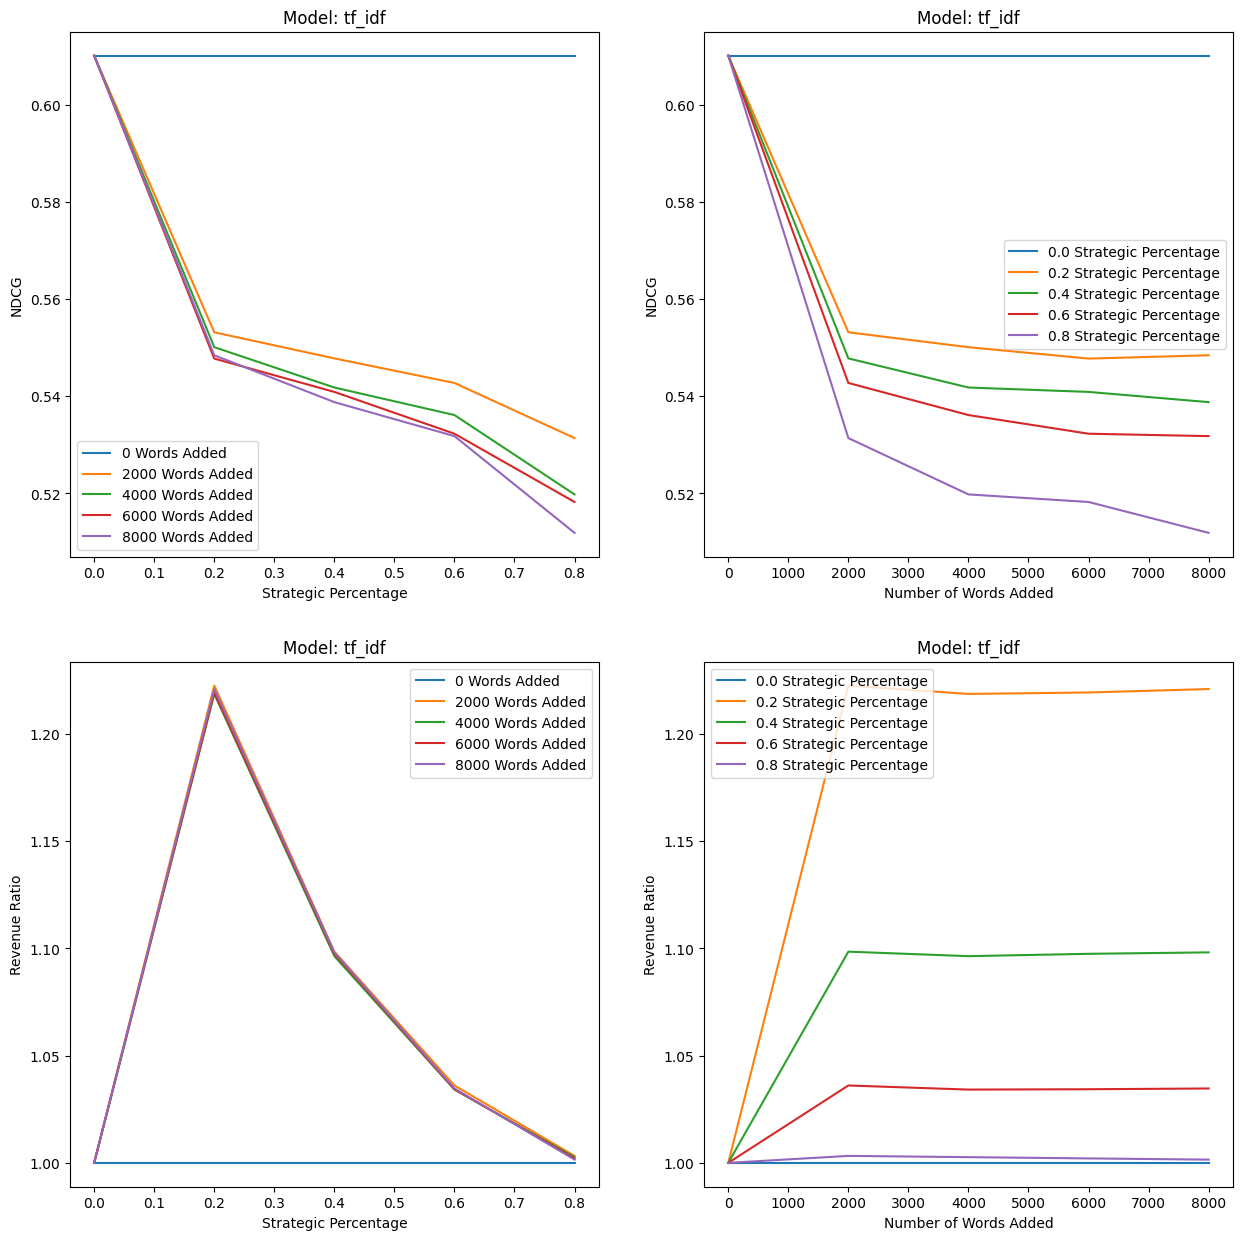

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


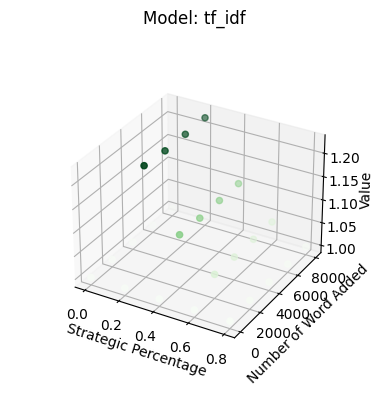

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


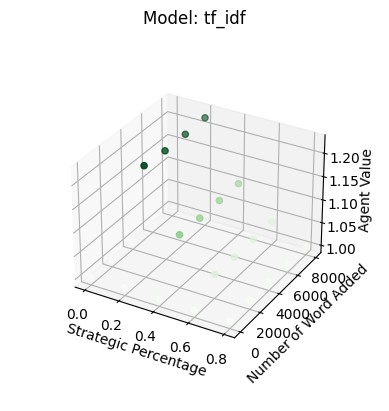


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [43:29<00:00, 521.94s/it]


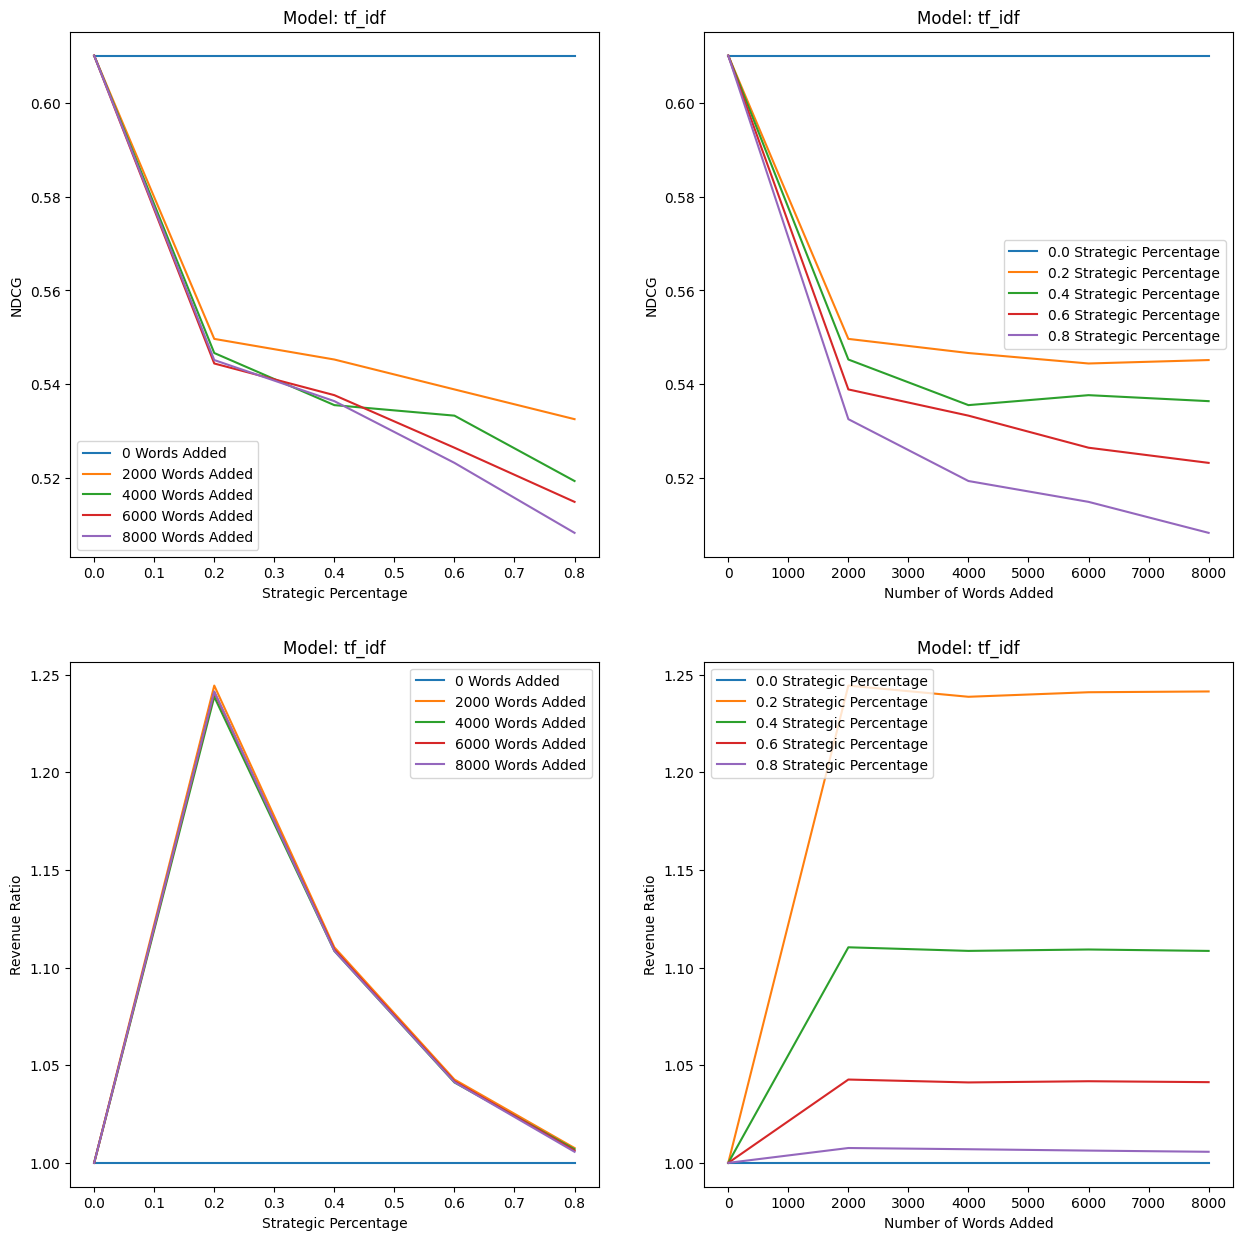

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


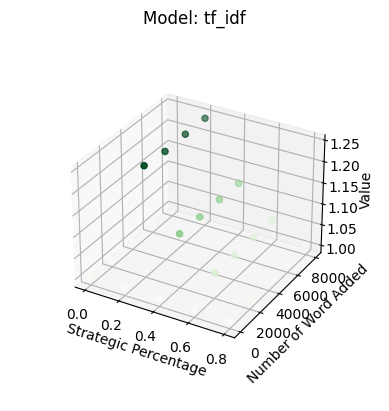

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


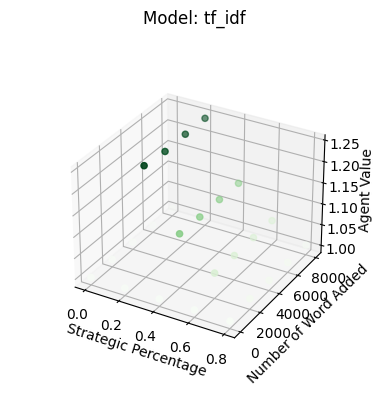

In [8]:
for k in range(1, 5):
    run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf", k=k, strategy="top_k_softmax")

In this experiment, the TF-IDF model was employed once again, utilizing the top_k_softmax approach. The results obtained were similar to those previously observed, with slight discrepancies in the values but upheld order relations, thereby permitting the same inferences to be made. The consistent findings across the aforementioned experiments employing distinct strategies suggests the robustness of the results, with a heightened level of confidence.
In the case of this strategy (Top K Softmax) we can see that k equals one is different from the rest (higher NDCG and lower agents' value), but K equals 2 to 4 looks almost the same.


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 1


100%|██████████| 5/5 [19:25<00:00, 233.12s/it]


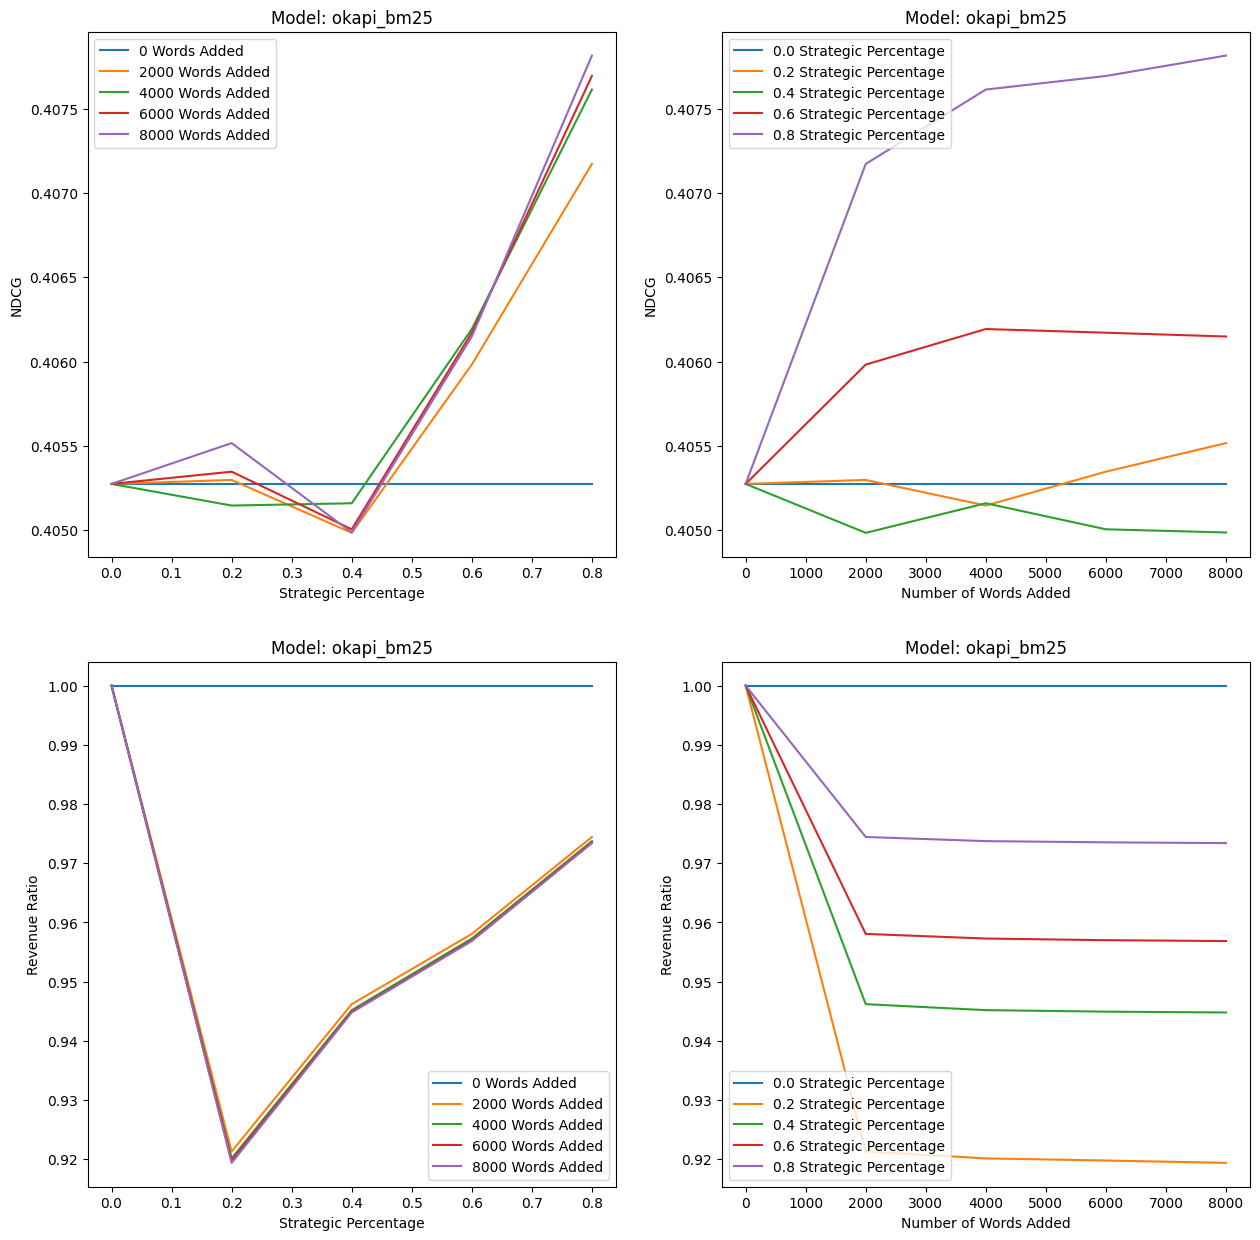

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


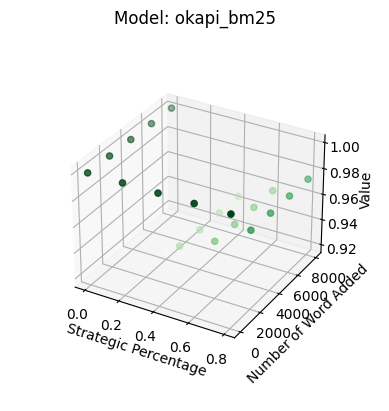

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


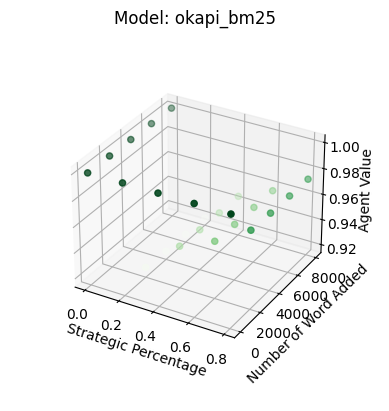


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 2


100%|██████████| 5/5 [19:32<00:00, 234.41s/it]


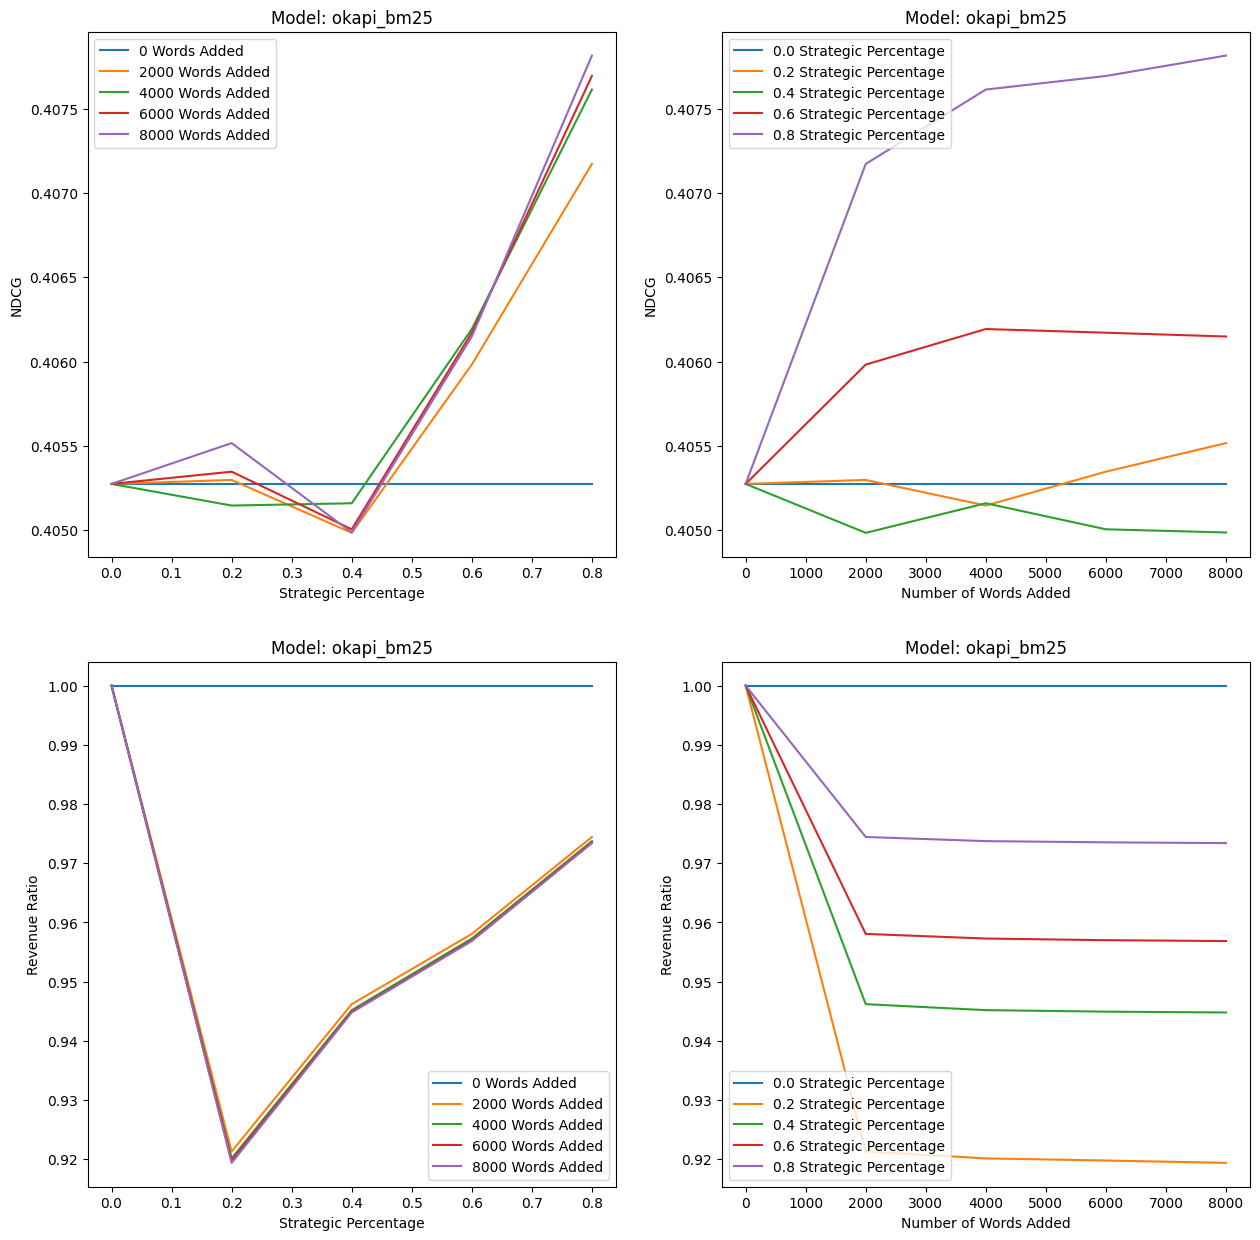

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


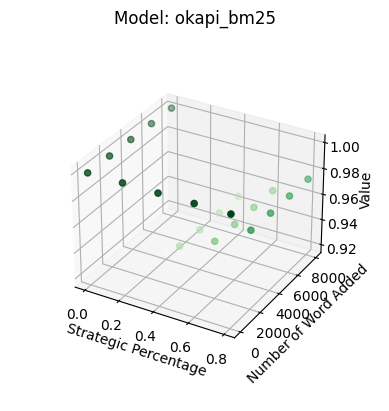

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


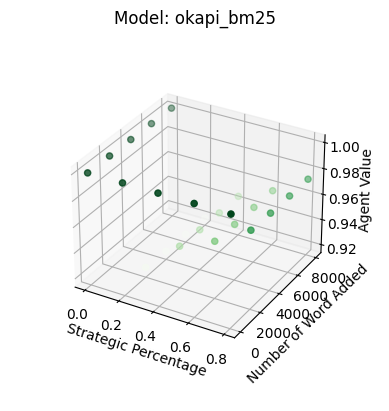


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 3


100%|██████████| 5/5 [19:31<00:00, 234.35s/it]


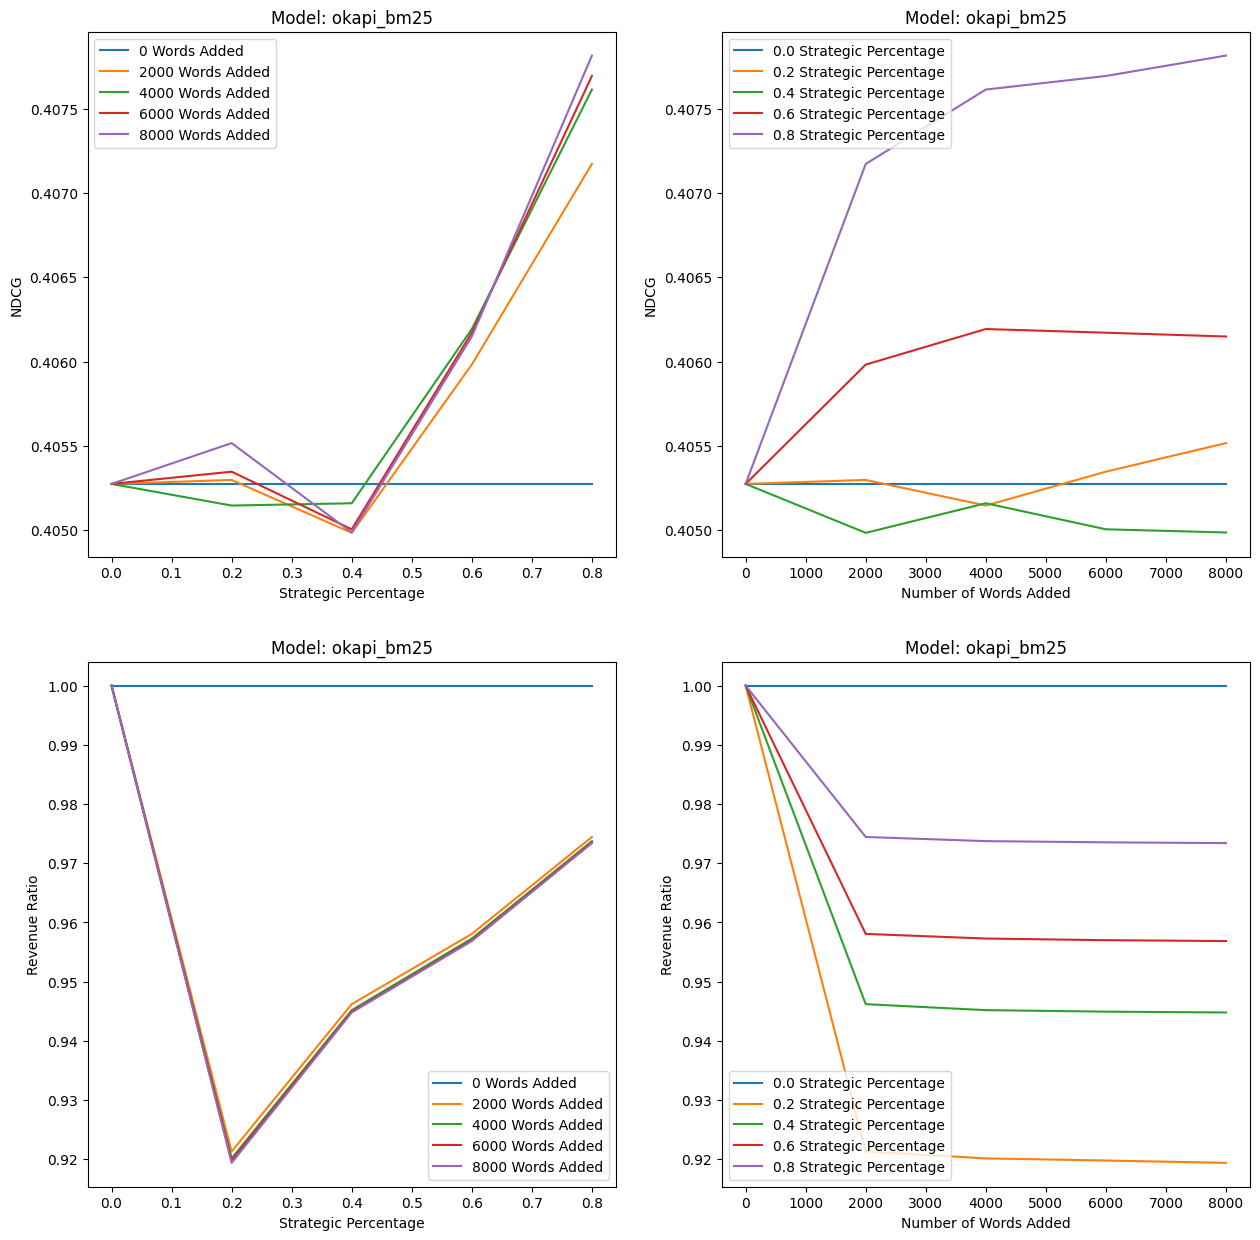

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


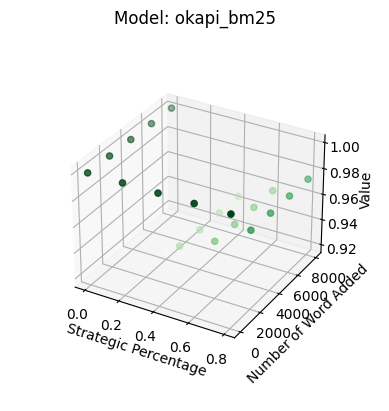

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


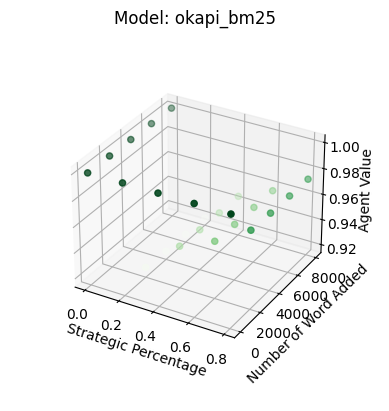


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [19:31<00:00, 234.31s/it]


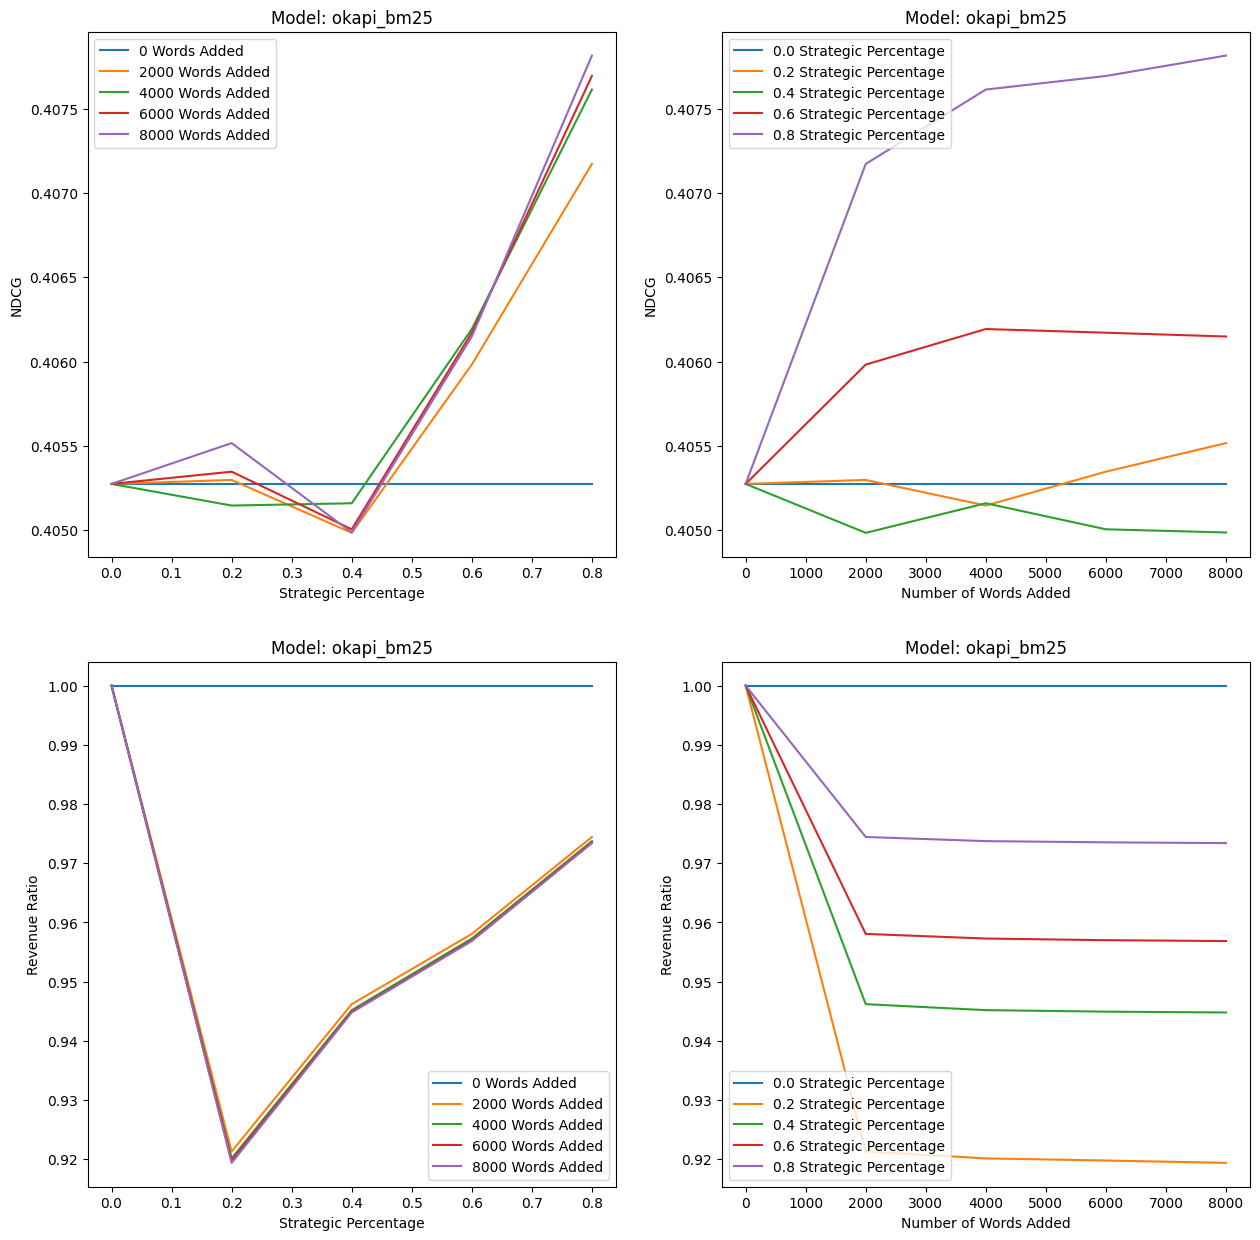

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


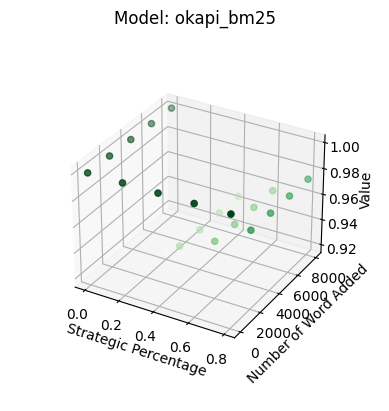

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


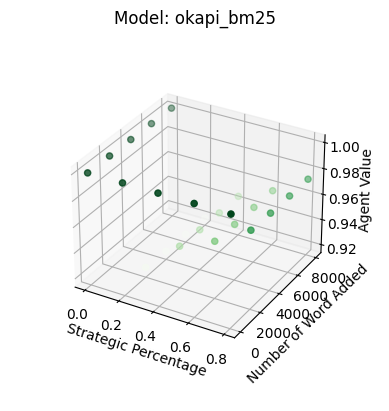

In [9]:
for k in range(1, 5):
    run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "okapi_bm25", k=k, strategy="top_k_softmax")

As we can see even with a different strategy, and various hyper-parameters the results are similar to the previous experiment.


Model: rank_svm	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [2:24:34<00:00, 1734.90s/it]


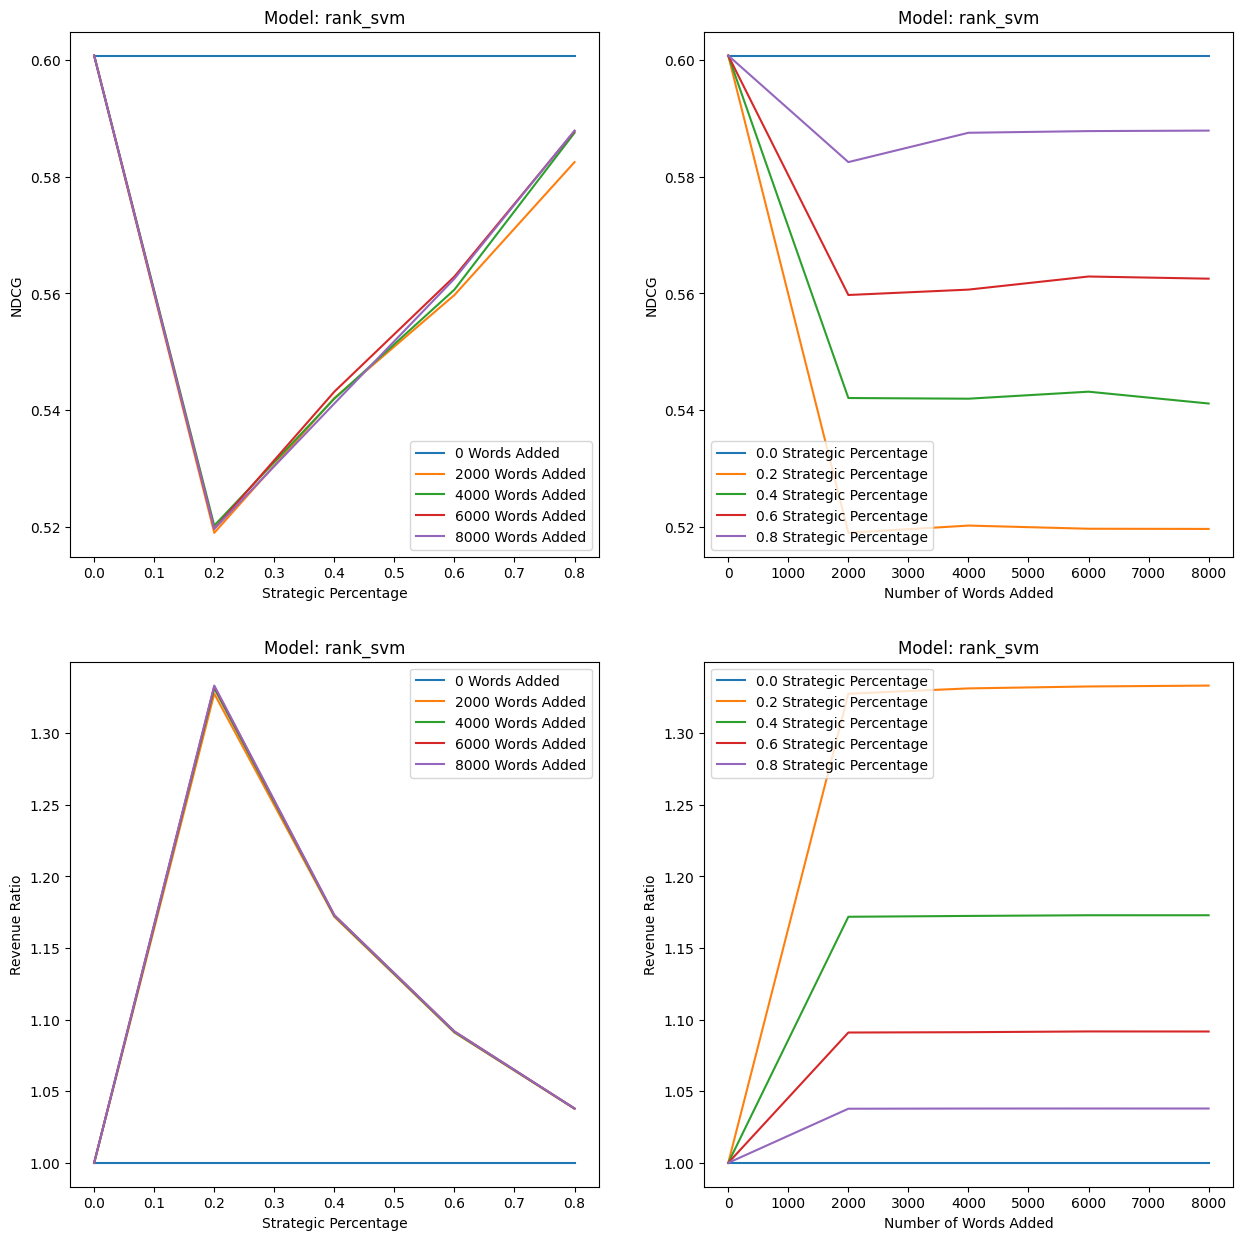

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:121: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


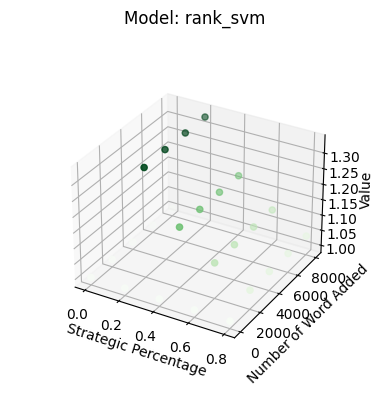

C:\Users\idozu\AppData\Local\Temp\ipykernel_1724\2099402359.py:134: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


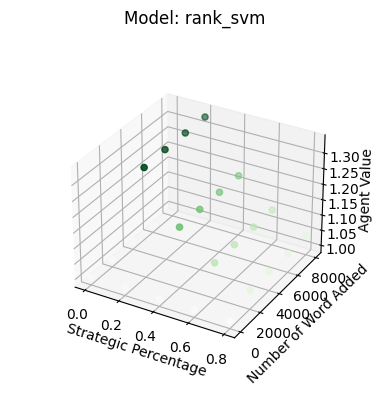

In [10]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "rank_svm")

In this experiment, the Rank SVM model was employed, utilizing the dominant_word_not_present approach. As we can see the presents of the strategic agent does affect the system performance and makes poorer results. but we can see that as the strategic percentage increases the NDCG improves compared to the case of low but non-zero percentage of strategic agents, even though it is still lower than the base case. In addition, we see similar turn to the TF-IDF in regards to agents' revenue.

In [ ]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "rank_svm", strategy="dominant_word_not_present")


Model: rank_svm	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


 80%|████████  | 4/5 [1:50:05<27:48, 1668.31s/it]

In [ ]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "rank_svm", strategy="top_k_softmax", k=4)

Due to computational limitations, we were unable to run the experiments for the Rank SVM model utilizing the top_k_softmax strategy on each of the Ks, so we only ran it for K=4.

## Discussion
The TF-IDF model results looks as we expected, as we can see in the graphs, the NDCG is decreasing as the number of strategic agents increases or the number of added words increases. This make sense because if we are making more agents more strategics the system will lose from that.
As for the agents revenue, we can see that increasing the strategic percantage increases the agent revanue until some point when the agents harm each other which make their revenue to decrease.

The Okapi BM25 model results are not as expected, as we can see in the graphs, the NDCG is increasing as the number of strategic agents increases or the number of added words increases. This does not make sense, but because we can see that the differences between the values are minor and relative to the TF-IDF model low, i.e., the baseline is bad, wwe can infer that caused because the model is not good for that task.

The Rank SVM model .................................

The different strategies give similar results in the same configuration - As we can see in the graphs, the 2 different strategies resulted in similar results in all the configurations. This indicates that as long as an agent applies a reasonable strategy in order to increase it’s location in the ranking, the details of the strategy seems to have minor influence. The only slightly different strategy is top k SoftMax with k=1, which basically means adding the most valuable word to the agent’s document, and it has slightly worst effect on the NDCG and the agent’s revenue, but the trends remain the same.
Top k SoftMax strategy is not affected by K as we expected – We believed we will have different results between different values of K in the strategy SoftMax top k, even though we could not predict the affect of K on the metrics we checked. In the end we add only a slight affect of the value of K. If K was 1, the effects on the NDCG and strategic agent’s revenue were more subtle then for other K values. The big surprise was that the results did not seem to change at all for K = 2 to 4. This might be because in the distribution created using the SoftMax, the first 2 words take most of the distribution, and therefore other words rarely appear. An interesting follow up experiment can be changing the temperature to see if it affects the distribution and then K does influence the results in higher values (3 and up).
In conclusion, we can see that the strategic behavior of content creators does affect the overall performance of the system, but only of the baseline of the system stands at a certain threshold, otherwise the affects are minor and can create the opposing affect (as seen in the OKAPI case).It also might depend on the model being used and the amount of strategic agents- in tf-idf model we seen that more strategic agents means worse performance from the system, but in rank SVM the results might improve with a lot of strategic agents compared to little strategic agents.
In addition, we can see that the strategic behavior of content creators does increase their revenue, and it does seem to decrease with more strategic agents, but we were unable to determine the exact point the revenue starts to decrease.
Our final conclusion is that strategic behavior is always good for content creators, but it is better when there are a lot of strategic agents. And as it appears, the models are robust enough for the results not to suffer too much (only 10% decrease in the NDCG at the worst case), but they are affected.


## Limitations and Criticism
* We check only 2 strategies- in our work we only looked on 2 strategies. There is an unlimited number of strategies that can be applied, and their results might contradict our findings.
* Queries worth was assigned randomly- the worth assigned to queries was random, but in the real world we know this is not the case (a query about finding a new car is almost always worth more than a query looking for pair of socks).
* We checked only on one dataset- all of our findings are based only on one dataset, the ciri dataset. Given other datasets the results can be very different. For example, the results of OKAPI BM25 can be good and then we were able to see it’s behavior when the model fits the data, which is not the case here.
* computationally unable to check more configurations – We would have liked to check more configuration to see the effects of different K and temperatures in the top k SoftMax strategy, more configuration on the number of words and strategic agents, but as all the runs take a lot of times, we add to make do with less results.
* Could not assess other affects of strategic behaviour on the systems performance (diversity, etc.)- NDCG is not the only way to see if an Information Retrieval system was affected, it is possible other things in the system were affected, for example the diversity of the top results, user’s satisfaction from the ranked list and so on. Those metrics require access to data we don’t have, so we had to settle for a metric that checks just the quality of the ranking based on binary annotation on the documents.
